# TUTORIAL PYTORCH
## Entrenando un Clasificador
###### Fuente: [Documentación Oficial de Pytorch](https://pytorch.org/tutorials/)
###### Edición y traducción por Cristobal Donoso O. 
###### Agosto 2018

Hasta ahora hemos visto como definir redes neuronales, computar la perdida y realizar las actualizaciones de los pesos. Solo nos queda trabajar con los **datos**. En general, tu puedes trabajar con librerias estandar de python para cargar y manipular los datos.<br><br>
Por otro lado, Pytorch posee un paquete llamado ```torchvision``` que contiene datasets de imagenes tales como Imagenet, CIFAR10, MNIST, etc. ```torchvision.datasets```  y algunas funciones para trabajar con los datos ```torch.utils.data.DataLoader```.<br><br>
En este tutorial utilizaremos CIFAR10. Este conjunto de datos contiene aviones, automoviles, pajaros, gatos, ciervos, perros, ranas, caballos, barcos y camiones. Las imagenes son de ```3x32x32``` 

### Objetivos del tutorial
- Cargar y generar los conjuntos de entrenamiento y prueba desde CIFAR10 usando ```torchvision``` 
- Deinir el modelo (Red Neuronal Convolucional)
- Definir un función de perdida
- Entrenar la red con el conjunto de entrenamiento
- Realizar pruebas con el conjunto de prueba

#### 1.Cargando y generando los subconjuntos para el entrenamiento desde CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision nos entrega imagenes en formato PILImage imagenes cuyo rango se encuentra entre $[0, 1]$. Transformaremos estas imagenes para crear Tensores normalizados en el rango $[-1,1]$

```torchvision.transforms``` contiene herramientas para aplicar transformaciones a imagenes. Podemos aplicar más de una transformación utilizando ```.Compose``` y listando las acciones

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [19]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('avion', 'auto', 'pajaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camion')

Files already downloaded and verified
Files already downloaded and verified


 rana perro  auto  auto


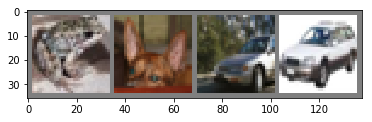

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar la imagen
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtenemos algunas imagenes aleatorias
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Mostrar imagenes
imshow(torchvision.utils.make_grid(images))

# Imprimir etiquetas
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

#### Definiendo el Modelo

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#### Definiendo la función de Perdida y el Optimizador

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Entrenando la red
Simplemente generamos un loop sobre el iterador de nuestros dataset y cargamos la entrada de la red. Finalmente, optimizamos. 

In [23]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.147
[1,  4000] loss: 1.829
[1,  6000] loss: 1.662
[1,  8000] loss: 1.565
[1, 10000] loss: 1.515
[1, 12000] loss: 1.456
[2,  2000] loss: 1.405
[2,  4000] loss: 1.362
[2,  6000] loss: 1.326
[2,  8000] loss: 1.305
[2, 10000] loss: 1.307
[2, 12000] loss: 1.259
Finished Training


#### Probando el Modelo
Una vez que hemos entrenado es necesario probarlo y comprobar que realmente aprendió - pudiendo eventualmente sobreajustar al conjunto de entrenamiento [(*)](https://en.wikipedia.org/wiki/Overfitting)

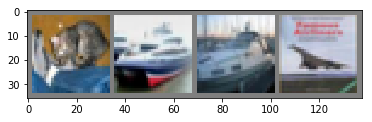

GroundTruth:   gato barco barco avion


In [24]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Ahora veamos que dice nuestro modelo 

In [25]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   gato barco  auto barco


Estos son resultados para un pequeño subconjunto. Consideremos todas las imagenes 

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


Podemos ver cuales son las clases que está detectando mejor y peor 

In [31]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Exactitud de %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Exactitud de avion : 58 %
Exactitud de  auto : 76 %
Exactitud de pajaro : 52 %
Exactitud de  gato : 42 %
Exactitud de ciervo : 38 %
Exactitud de perro : 42 %
Exactitud de  rana : 69 %
Exactitud de caballo : 63 %
Exactitud de barco : 55 %
Exactitud de camion : 59 %
